### Without semantics
#### Threshold and sparsity

In [1]:
import pandas as pd
import thesis_functions as tf
from aerial import model, rule_extraction, rule_quality
import numpy as np

In [4]:
# Load data
expr_matrix_raw = pd.read_csv('Data/gene_expr_matrix_VLCD_LCD_2timepoints.csv', index_col=0) 
metadata = pd.read_csv('Data/metadata_filtered_2timepoints_VLCD_LCD.csv', index_col=0)

# Rename expr_matrix_raw columns using super_id from metadata
expr_matrix_raw.columns = metadata.loc[expr_matrix_raw.columns, 'super_id'].astype(str).values

# Subset only one treatment
super_ids_VLCD = metadata.loc[metadata['treatment'] == 'very-low-calorie diet', 'super_id']
expr_matrix_raw = expr_matrix_raw.loc[:, expr_matrix_raw.columns.isin(super_ids_VLCD)]


# Subset significant genes only
sig_genenames = pd.read_csv('Data/sig_genenames_VLCD_LCD.csv')
expr_matrix_raw_sig = expr_matrix_raw.loc[expr_matrix_raw.index.intersection(sig_genenames['x'])]
expr_matrix_raw_sig.head()


,1A,1B,2A,2B,3A,3B,4A,4B,5A,5B,...,45B,46A,46B,47A,47B,52A,52B,55A,55B,61A
AACS,6.119484,5.954499,7.091046,6.204872,7.121898,6.431687,6.232337,6.074907,6.344019,6.358287,...,6.000650,6.916260,6.020237,7.183228,6.084343,6.511988,6.458463,6.691672,6.259456,6.996723
AADAC,5.742837,6.159056,5.218273,5.715436,4.773760,5.843851,4.095828,5.581445,5.422022,7.000329,...,6.144937,5.173941,4.819199,5.202143,5.537062,4.052324,5.434206,4.164337,5.446170,6.236813
ABCB11,3.263683,5.455237,3.001000,4.337801,4.846125,5.986115,3.291753,3.282246,5.509475,7.053325,...,4.981686,3.763709,3.637255,4.236047,4.937940,5.899767,6.817970,4.706861,7.076605,7.026304
ABCC6,6.248035,5.131170,5.641004,5.411726,5.767713,4.584088,5.599325,5.172479,4.439270,4.696274,...,5.369631,6.531842,5.602687,5.594228,4.904626,5.870304,5.420647,5.705527,5.300562,5.263231
ABCC6P2,6.358351,5.413584,6.062927,5.488108,6.240490,5.353764,6.527384,6.777927,4.606221,5.329591,...,5.505645,6.650421,6.050458,6.541816,5.500843,6.094665,5.428735,5.975307,5.406738,5.949176


In [ ]:
# Get log fold change df
logfc_df_sig = tf.GetFoldChangeDf(expr_matrix_raw_sig, subjects_as_rows=True)
logfc_df_sig.to_csv('Data/logfc_df_sig.csv', index=True)
logfc_df_sig =pd.read_csv('Data/logfc_df_sig.csv', index_col=0)
logfc_df_sig.head()


,AACS,AADAC,ABCB11,ABCC6,ABCC6P2,ABCD2,ABCG2,ACP5,ACSL1,ADA2,...,TM4SF19,TMEM120B,TNFRSF25,TREM2,TTTY9A,TYROBP,VLDLR,VLDLR-AS1,VSIG4,XAGE-4
1,-0.039430,0.100946,0.741141,-0.284115,-0.232069,-0.168558,0.327215,0.506237,-0.095969,0.391478,...,0.448900,-0.213575,-0.268039,0.678077,-0.071719,0.170318,-0.161612,-0.333405,0.214318,-0.251708
2,-0.192597,0.131291,0.531521,-0.059863,-0.143706,-0.149784,0.070619,0.476086,-0.060847,0.209558,...,0.672224,-0.149094,-0.157089,0.637887,-0.157853,0.153572,-0.178555,-0.211930,0.045925,-0.314178
3,-0.147065,0.291794,0.304789,-0.331365,-0.221106,-0.302054,0.347592,0.379529,-0.204408,0.317342,...,0.508138,-0.292315,-0.221201,0.642264,-1.125669,0.236148,-0.342431,-0.381639,0.230214,-0.622012
4,-0.036911,0.446484,-0.004173,-0.114397,0.054339,-0.028833,-0.076611,0.161071,-0.007258,-0.049478,...,-0.122699,-0.013519,-0.045466,0.061483,-0.284659,0.088979,0.057077,0.029317,0.176578,-0.218297
5,0.003241,0.368592,0.356389,0.081194,0.210441,-0.005436,0.253976,0.487238,0.024461,0.449041,...,0.580661,-0.053006,-0.215984,0.601606,-0.569379,0.242625,0.026915,-0.069770,0.438672,0.340742


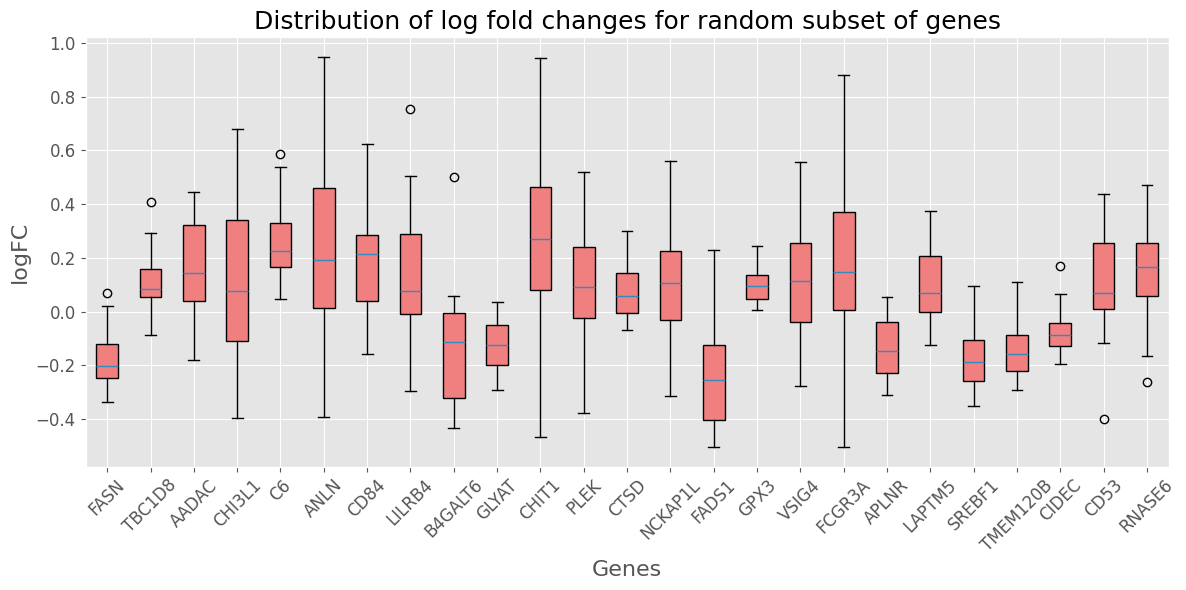

In [ ]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

# Select a random subset of genes
subset = tf.randomly_downsize(logfc_df_sig, row_frac=1, col_frac=0.10, random_state=30)

# Create the figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Create the boxplot with patch_artist=True
box = ax.boxplot(subset.values, patch_artist=True, showfliers=True)

# Set x-tick labels to column names
ax.set_xticklabels(subset.columns, rotation=45, fontsize=12)

# Fill the boxes with light cyan
for patch in box['boxes']:
    patch.set_facecolor('lightcoral')

# Set title and labels with increased font size
ax.set_title('Distribution of log fold changes for random subset of genes', fontsize=18)
ax.set_ylabel('logFC', fontsize=16)
ax.set_xlabel('Genes', fontsize=16)

# Increase y-tick label font size
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()


In [6]:
import time 
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules
import numpy as np



In [8]:
# Create a smaller df to speed up things 
logfc_df_small = tf.randomly_downsize(logfc_df_sig, row_frac=1, col_frac=0.5, random_state=50)

# APPLY THRESHOLD FOR CHANGE IN EXPRESSION AND USE THIS TO MAKE A ONE HOT DF
transaction_df = tf.MakeOneHotDf(logfc_df_small, 0.3, expand_columns=True)

transaction_df.describe
# 1. Fraction of 1s per column
fraction_per_column = transaction_df.mean()

# 2. Total fraction of 1s in the whole DataFrame
total_fraction = transaction_df.values.sum() /transaction_df.size

# Display results
print("Fraction of 1s per column:\n", fraction_per_column)
print("\nTotal fraction of 1s in the DataFrame:", total_fraction)

#

Fraction of 1s per column:
 AADAC_downregulated      0.000000
AADAC_upregulated        0.291667
ABCB11_downregulated     0.000000
ABCB11_upregulated       0.333333
ABCC6_downregulated      0.083333
                           ...   
VLDLR-AS1_upregulated    0.000000
VLDLR_downregulated      0.083333
VLDLR_upregulated        0.000000
XAGE-4_downregulated     0.375000
XAGE-4_upregulated       0.083333
Length: 250, dtype: float64

Total fraction of 1s in the DataFrame: 0.10183333333333333


In [ ]:
logfc_df_small.head()

In [9]:
import pandas as pd 
import random
import time

thresholds = [0.5, 0.3, 0.2, 0.1, 0.05, 0.02]
colnames = ['Non-zero fraction', 'FP-growth exec time', 'FP-growth nr_rules', 'FP_growth minimum support', 'Aerial exec time (avg)', 'Aerial nr_rules (avg)',
             'Aerial confidence (avg)', 'Aerial support (avg)']
results = pd.DataFrame(index=thresholds, columns=colnames)

min_sup = 0.6
min_conf = 0.8

for threshold in thresholds: 
    print(threshold)
    transaction_df = tf.MakeOneHotDf(logfc_df_small, threshold, expand_columns=True)
    print(f"Threshold: {threshold}, Shape: {transaction_df.shape}, Non-zero count: {transaction_df.sum().sum()}")
    results.loc[threshold, 'Non-zero fraction'] = round((transaction_df.sum().sum()/(transaction_df.shape[0]*transaction_df.shape[1])), 2)
    runtimes = []
    nr_rules = []
    confidences = []
    supports =[]
    coverages = []
    zhangs = []
    for i in range(5):
        try: 
            start_time_ = time.time()
            from aerial import model
            trained_autoencoder = model.train(transaction_df, epochs=5)
            features_of_interest = [{column_name.split("__")[0]: str(1)} for column_name in trained_autoencoder.feature_values
                            if column_name and not column_name.endswith("__0")]
            rules = rule_extraction.generate_rules(trained_autoencoder, ant_similarity=min_sup, cons_similarity=min_conf, max_antecedents=2,
                                                    features_of_interest=features_of_interest, target_classes=features_of_interest) #added later to comply with new aerial and not inclue __00 z
            exec_time = time.time() - start_time_
            if len(rules) > 0:  #calculate stats
                print(f"Generated {len(rules)} rules at threshold {threshold}")
                nr_rules.append(len(rules))
                stats = rule_quality.calculate_rule_stats(rules, transactions=trained_autoencoder.input_vectors, max_workers=4)
                summary_stats = stats[0]  
                support = summary_stats['average_support']
                confidence = summary_stats['average_confidence']
                zhangs_metric = summary_stats['average_zhangs_metric']
                coverage = summary_stats['data_coverage']
                confidences.append(confidence)
                supports.append(support)
                zhangs.append(zhangs_metric)
                coverages.append(coverage)
                runtimes.append(exec_time)
        except Exception as e:
            print(f"Run {i+1} failed: {e}")
            continue
    results.loc[threshold, 'Aerial exec time (avg)'] = np.mean(runtimes) if runtimes else None
    results.loc[threshold, 'Aerial nr_rules (avg)'] = np.mean(nr_rules) if nr_rules else None
    results.loc[threshold, 'Aerial confidence (avg)'] = np.mean(confidences) if confidences else None
    results.loc[threshold, 'Aerial support (avg)'] = np.mean(supports) if supports else None
    results.loc[threshold, 'Aerial Zhangs metric (avg)'] = np.mean(zhangs) if zhangs else None
    results.loc[threshold, 'Aerial coverage (avg)'] = np.mean(coverages) if coverages else None
    print (results)

    # FP growth part
    
    min_sup_fp =  np.mean(supports)/2 if supports else min_sup
    print(f"using min support fp = {min_sup_fp}")
    start_time = time.time()
    freq_itemsets = fpgrowth(df= transaction_df, min_support=min_sup_fp, use_colnames=True, verbose=False, max_len=3)
    fp_time = time.time() - start_time

    try:
        rules = association_rules(freq_itemsets, metric="confidence", min_threshold=min_conf)
        fp_time = time.time() - start_time
        results.loc[threshold, 'FP-growth exec time'] = round(fp_time, 2)
        results.loc[threshold, 'FP-growth minimun support'] = round(min_sup_fp, 2)
        results.loc[threshold, 'FP-growth nr_rules'] = len(rules)
    except:
        results.loc[threshold, 'FP-growth exec time'] = round(fp_time, 2)
        results.loc[threshold, 'FP-growth nr_rules'] = 0

results


0.5
Threshold: 0.5, Shape: (24, 250), Non-zero count: 209
Generated 15 rules at threshold 0.5
     Non-zero fraction FP-growth exec time FP-growth nr_rules  \
0.50              0.03                 NaN                NaN   
0.30               NaN                 NaN                NaN   
0.20               NaN                 NaN                NaN   
0.10               NaN                 NaN                NaN   
0.05               NaN                 NaN                NaN   
0.02               NaN                 NaN                NaN   

     FP_growth minimum support Aerial exec time (avg) Aerial nr_rules (avg)  \
0.50                       NaN                9.93238                  15.0   
0.30                       NaN                    NaN                   NaN   
0.20                       NaN                    NaN                   NaN   
0.10                       NaN                    NaN                   NaN   
0.05                       NaN                    NaN  

/Users/louisebuijs/Documents/DataScience Master/Thesis/.venv/lib/python3.11/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Generated 234 rules at threshold 0.3
Generated 2116 rules at threshold 0.3
Generated 56 rules at threshold 0.3
Generated 1071 rules at threshold 0.3
Generated 10 rules at threshold 0.3
     Non-zero fraction FP-growth exec time FP-growth nr_rules  \
0.50              0.03                0.05                489   
0.30               0.1                 NaN                NaN   
0.20               NaN                 NaN                NaN   
0.10               NaN                 NaN                NaN   
0.05               NaN                 NaN                NaN   
0.02               NaN                 NaN                NaN   

     FP_growth minimum support Aerial exec time (avg) Aerial nr_rules (avg)  \
0.50                       NaN                9.93238                  15.0   
0.30                       NaN              10.918749                 697.4   
0.20                       NaN                    NaN                   NaN   
0.10                       NaN             

/Users/louisebuijs/Documents/DataScience Master/Thesis/.venv/lib/python3.11/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


0.2
Threshold: 0.2, Shape: (24, 250), Non-zero count: 1130
Generated 142886 rules at threshold 0.2
Generated 144 rules at threshold 0.2
Generated 2842 rules at threshold 0.2
Generated 455 rules at threshold 0.2
Generated 74214 rules at threshold 0.2
     Non-zero fraction FP-growth exec time FP-growth nr_rules  \
0.50              0.03                0.05                489   
0.30               0.1                3.22              44693   
0.20              0.19                 NaN                NaN   
0.10               NaN                 NaN                NaN   
0.05               NaN                 NaN                NaN   
0.02               NaN                 NaN                NaN   

     FP_growth minimum support Aerial exec time (avg) Aerial nr_rules (avg)  \
0.50                       NaN                9.93238                  15.0   
0.30                       NaN              10.918749                 697.4   
0.20                       NaN              11.166261    

/Users/louisebuijs/Documents/DataScience Master/Thesis/.venv/lib/python3.11/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


0.1
Threshold: 0.1, Shape: (24, 250), Non-zero count: 1950
Generated 1865 rules at threshold 0.1
Generated 40668 rules at threshold 0.1
Generated 4350 rules at threshold 0.1
Generated 11131 rules at threshold 0.1
Generated 218948 rules at threshold 0.1
     Non-zero fraction FP-growth exec time FP-growth nr_rules  \
0.50              0.03                0.05                489   
0.30               0.1                3.22              44693   
0.20              0.19               19.43             220708   
0.10              0.32                 NaN                NaN   
0.05               NaN                 NaN                NaN   
0.02               NaN                 NaN                NaN   

     FP_growth minimum support Aerial exec time (avg) Aerial nr_rules (avg)  \
0.50                       NaN                9.93238                  15.0   
0.30                       NaN              10.918749                 697.4   
0.20                       NaN              11.166261 

/Users/louisebuijs/Documents/DataScience Master/Thesis/.venv/lib/python3.11/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


0.05
Threshold: 0.05, Shape: (24, 250), Non-zero count: 2495
Generated 111045 rules at threshold 0.05
Generated 61711 rules at threshold 0.05
Generated 188253 rules at threshold 0.05
Generated 161160 rules at threshold 0.05
Generated 27249 rules at threshold 0.05
     Non-zero fraction FP-growth exec time FP-growth nr_rules  \
0.50              0.03                0.05                489   
0.30               0.1                3.22              44693   
0.20              0.19               19.43             220708   
0.10              0.32               72.73             514926   
0.05              0.42                 NaN                NaN   
0.02               NaN                 NaN                NaN   

     FP_growth minimum support Aerial exec time (avg) Aerial nr_rules (avg)  \
0.50                       NaN                9.93238                  15.0   
0.30                       NaN              10.918749                 697.4   
0.20                       NaN             

/Users/louisebuijs/Documents/DataScience Master/Thesis/.venv/lib/python3.11/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


0.02
Threshold: 0.02, Shape: (24, 250), Non-zero count: 2797
Generated 265680 rules at threshold 0.02
Generated 506610 rules at threshold 0.02
Generated 316800 rules at threshold 0.02
Generated 550537 rules at threshold 0.02
Generated 279503 rules at threshold 0.02
     Non-zero fraction FP-growth exec time FP-growth nr_rules  \
0.50              0.03                0.05                489   
0.30               0.1                3.22              44693   
0.20              0.19               19.43             220708   
0.10              0.32               72.73             514926   
0.05              0.42               82.52             863145   
0.02              0.47                 NaN                NaN   

     FP_growth minimum support Aerial exec time (avg) Aerial nr_rules (avg)  \
0.50                       NaN                9.93238                  15.0   
0.30                       NaN              10.918749                 697.4   
0.20                       NaN           

/Users/louisebuijs/Documents/DataScience Master/Thesis/.venv/lib/python3.11/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,Non-zero fraction,FP-growth exec time,FP-growth nr_rules,FP_growth minimum support,Aerial exec time (avg),Aerial nr_rules (avg),Aerial confidence (avg),Aerial support (avg),Aerial Zhangs metric (avg),Aerial coverage (avg),FP-growth minimun support
0.50,0.03,0.05,489,NaN,9.93238,15.0,0.965,0.169,0.7470,0.5830,0.08
0.30,0.1,3.22,44693,NaN,10.918749,697.4,0.712,0.2124,0.3752,0.9414,0.11
0.20,0.19,19.43,220708,NaN,11.166261,44108.2,0.747,0.2326,0.3432,1.0000,0.12
0.10,0.32,72.73,514926,NaN,11.601199,55392.4,0.7552,0.324,0.1996,1.0000,0.16
0.05,0.42,82.52,863145,NaN,13.725563,109883.6,0.7626,0.3792,0.1664,1.0000,0.19
0.02,0.47,89.79,1062628,NaN,17.657578,383826.0,0.8204,0.4922,0.1430,1.0000,0.25


In [12]:
#results = results.drop(columns='FP_growth minimum support')
results.to_csv('Results/thresholding_Aerial_FP_growth')
print(results)

     Non-zero fraction FP-growth exec time FP-growth nr_rules  \
0.50              0.03                0.05                489   
0.30               0.1                3.22              44693   
0.20              0.19               19.43             220708   
0.10              0.32               72.73             514926   
0.05              0.42               82.52             863145   
0.02              0.47               89.79            1062628   

     Aerial exec time (avg) Aerial nr_rules (avg) Aerial confidence (avg)  \
0.50                9.93238                  15.0                   0.965   
0.30              10.918749                 697.4                   0.712   
0.20              11.166261               44108.2                   0.747   
0.10              11.601199               55392.4                  0.7552   
0.05              13.725563              109883.6                  0.7626   
0.02              17.657578              383826.0                  0.8204   

    

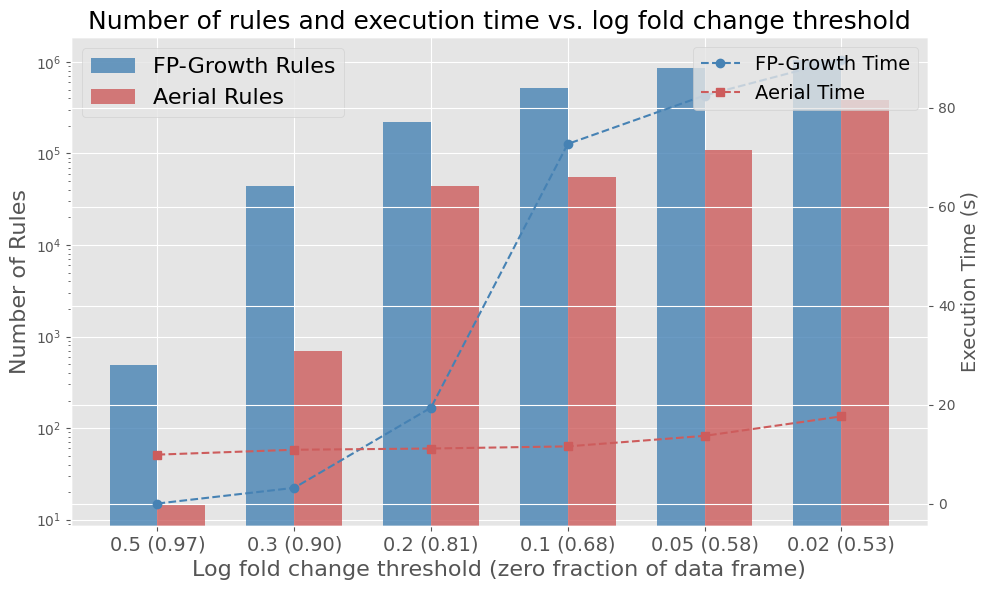

In [13]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')

# Clean and prepare data
fp_rules = pd.to_numeric(results['FP-growth nr_rules'], errors='coerce').fillna(0)
aerial_rules = pd.to_numeric(results['Aerial nr_rules (avg)'], errors='coerce').fillna(0)
fp_times = pd.to_numeric(results['FP-growth exec time'], errors='coerce').fillna(0)
aerial_times = pd.to_numeric(results['Aerial exec time (avg)'], errors='coerce').fillna(0)

thresholds = list(results.index)
non_zero_fraction = pd.to_numeric(1- results['Non-zero fraction'])  # put this under the thresholds. it provides information about effect of thresholdig
x = np.arange(len(thresholds))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10, 6))
# Plot rule count bars with log scale
bars1 = ax1.bar(x - width/2, fp_rules, width, label='FP-Growth Rules', color='steelblue', alpha=0.8)
bars2 = ax1.bar(x + width/2, aerial_rules, width, label='Aerial Rules', color='indianred', alpha=0.8)
ax1.set_ylabel('Number of Rules', fontsize=16)
ax1.set_xlabel('Log fold change threshold (zero fraction of data frame)',fontsize=16)
ax1.set_xticks(x)
# Updated tick labels with non-zero fractions
xtick_labels = [f"{thresh} ({frac:.2f})" for thresh, frac in zip(thresholds, non_zero_fraction)]
ax1.set_xticklabels(xtick_labels, fontsize=14)
ax1.set_yscale('log')
ax1.legend(loc='upper left', fontsize=16)

# Plot runtime markers
ax2 = ax1.twinx()
ax2.plot(x, fp_times, 'o--', color='steelblue', label='FP-Growth Time')
ax2.plot(x, aerial_times, 's--', color='indianred', label='Aerial Time')
ax2.set_ylabel('Execution Time (s)',fontsize=14)
ax2.legend(loc='upper right', fontsize=14)

plt.title('Number of rules and execution time vs. log fold change threshold', fontsize=18)
plt.tight_layout()
plt.show()
